***Fichier de création du model K-mean***

*chargement des données depuis MongoDB*

In [1]:
from pymongo import MongoClient
import pandas as pd

# Connexion à MongoDB
client = MongoClient("mongodb://localhost:27018")
db = client["my_database"]
collection = db["my_collection"]

# Charger les données
data = list(collection.find({}, {"_id": 0, "Nom du dépôt": 1, "Topics": 1, "Description": 1, "README": 1}))

# Convertir en DataFrame Pandas
df = pd.DataFrame(data)
df["combined_text"] = df["Nom du dépôt"] + " " + df["Topics"].apply(lambda x: " ".join(x) if isinstance(x, list) else "") + " " + df["Description"] + " " + df["README"]
print(df.head())
print(df.shape)


             Nom du dépôt                                             Topics  \
0            freeCodeCamp  ['learn-to-code', 'nonprofits', 'programming',...   
1  free-programming-books  ['education', 'books', 'list', 'resource', 'ha...   
2                 awesome  ['awesome', 'awesome-list', 'unicorns', 'lists...   
3        build-your-own-x  ['programming', 'tutorials', 'tutorial-code', ...   
4             public-apis  ['api', 'public-apis', 'free', 'apis', 'list',...   

                                         Description  \
0  freeCodeCamp.org's open-source codebase and cu...   
1         :books: Freely available programming books   
2  😎 Awesome lists about all kinds of interesting...   
3  Master programming by recreating your favorite...   
4                     A collective list of free APIs   

                                              README  \
0  freeCodeCamp.org's open-source codebase and cu...   
1  List of Free Learning Resources In Many Langua...   
2  Check out m

*Prétraiter les données textuelles*

In [2]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk

# Télécharger les stopwords de nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Fonction de nettoyage
def clean_text(text):
    text = text.lower()  # Convertir en minuscules
    text = re.sub(r'[^\w\s]', '', text)  # Supprimer la ponctuation
    text = re.sub(r'\d+', '', text)  # Supprimer les chiffres
    tokens = text.split()  # Tokeniser
    tokens = [word for word in tokens if word not in stop_words]  # Supprimer les stopwords
    return " ".join(tokens)

# Appliquer le nettoyage
df["cleaned_text"] = df["combined_text"].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leono\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


*Transformer le texte en vecteurs d'embedding*

In [3]:
#Avec TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # Limite les dimensions
X1 = vectorizer.fit_transform(df["cleaned_text"]).toarray()

#Avec sentence-transformers
from sentence_transformers import SentenceTransformer

# Charger un modèle de Sentence Transformers - embeddings plus riches
model = SentenceTransformer('all-MiniLM-L6-v2')

# Convertir les textes en embeddings
X = model.encode(df["cleaned_text"].tolist())

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

C:\Users\leono\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\leono\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

*Appliquer l'algorithme K-Means*

In [4]:
import mlflow
import mlflow.sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import os



mlflow.set_tracking_uri("http://localhost:5000")

# Initialiser MLflow
mlflow.set_experiment("KMeans Clustering Experiment")

os.environ["OMP_NUM_THREADS"] = "1"  # Éviter les erreurs de leak de mémoire

# Déterminer le nombre optimal de clusters avec la silhouette analysis
silhouette_scores = []
inertia = []
K = range(2, min(10, X.shape[0] + 1))  # Limiter K au nombre d'échantillons


with mlflow.start_run():
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        
        silhouette_scores.append(score)
        inertia.append(kmeans.inertia_)

        # Enregistrer les métriques dans MLflow
        mlflow.log_metric(f"silhouette_score_k{k}", score)
        mlflow.log_metric(f"inertia_k{k}", kmeans.inertia_)

    # Tracer la courbe d'inertie et l'enregistrer
    plt.figure(figsize=(8, 5))
    plt.plot(K, inertia, marker='o')
    plt.xlabel('Nombre de clusters (k)')
    plt.ylabel('Inertie')
    plt.title('Méthode du coude pour choisir k')
    plt.savefig("mlruns/elbow_method.png")
    mlflow.log_artifact("mlruns/elbow_method.png")  # Enregistrer l’image dans MLflow
    plt.close()

    # Tracer le score de silhouette et l'enregistrer
    plt.figure(figsize=(8, 5))
    plt.plot(K, silhouette_scores, marker='o')
    plt.xlabel('Nombre de clusters (k)')
    plt.ylabel('Score de silhouette')
    plt.title('Analyse de silhouette pour choisir k')
    plt.savefig("mlruns/silhouette_analysis.png")
    mlflow.log_artifact("mlruns/silhouette_analysis.png")  # Enregistrer l’image dans MLflow
    plt.close()

    # Trouver le k optimal
    optimal_k = K[silhouette_scores.index(max(silhouette_scores))]
    mlflow.log_param("optimal_k", optimal_k)  # Enregistrer k optimal

    print(f"Le nombre optimal de clusters selon l'analyse de silhouette est : {optimal_k}")

    # Appliquer K-Means avec le k optimal
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    df["cluster"] = kmeans.fit_predict(X)

    # Enregistrer le modèle K-Means dans MLflow
    mlflow.sklearn.log_model(kmeans, "KMeans_Model")

    print("Modèle K-Means enregistré avec MLflow !")

Le nombre optimal de clusters selon l'analyse de silhouette est : 2


2025/03/06 18:39:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle K-Means enregistré avec MLflow !
🏃 View run gentle-crab-991 at: http://localhost:5000/#/experiments/1/runs/33fa895f35984f84bc3b6cb8c7799005
🧪 View experiment at: http://localhost:5000/#/experiments/1


*Interpréter les résultats*

In [9]:
# Afficher les données regroupées par cluster
for cluster in range(optimal_k):
    print(f"\nCluster {cluster}:")
    print(df[df["cluster"] == cluster][["Nom du dépôt"]])



Cluster 0:
                Nom du dépôt
0               freeCodeCamp
1     free-programming-books
2                    awesome
3           build-your-own-x
4                public-apis
...                      ...
1043                   aider
1044               firecrawl
1045                  crewAI
1046                 ghostty
1047                it-tools

[939 rows x 1 columns]

Cluster 1:
                      Nom du dépôt
30                        CS-Notes
38                 Python-100-Days
41                       JavaGuide
48               fucking-algorithm
57    free-programming-books-zh_CN
...                            ...
978       everyone-can-use-english
983                   fe-interview
1005                 toBeTopJavaer
1015                         v2ray
1042                        hutool

[109 rows x 1 columns]


*Visualisation*

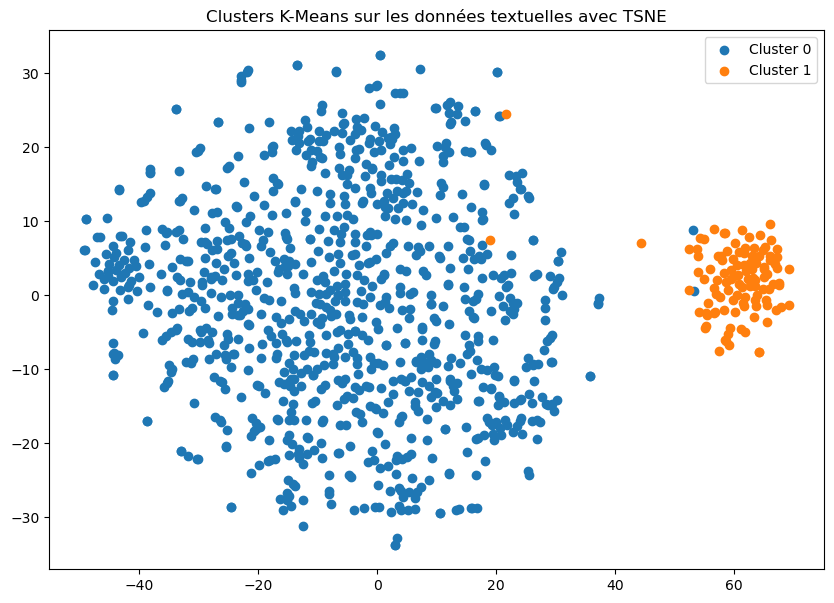

In [9]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Vérifier la taille des données
n_samples = X.shape[0]
perplexity = min(30, n_samples - 1)  # La perplexité doit être inférieure au nombre d'échantillons

# Réduction de dimensions
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
X_2d = tsne.fit_transform(X)

# Tracer les clusters
plt.figure(figsize=(10, 7))
for cluster in range(optimal_k):
    plt.scatter(X_2d[df["cluster"] == cluster, 0], X_2d[df["cluster"] == cluster, 1], label=f"Cluster {cluster}")

plt.legend()
plt.title("Clusters K-Means sur les données textuelles avec TSNE")
plt.show()


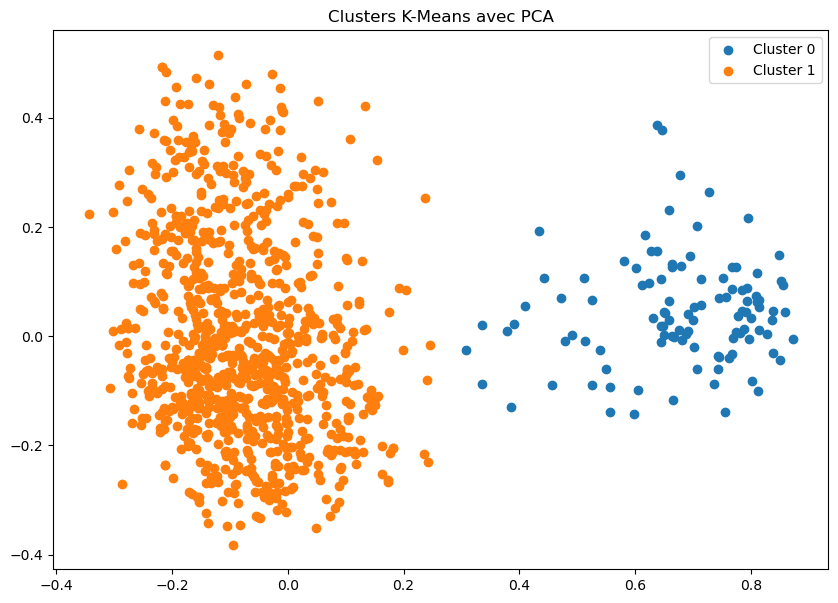

In [8]:
from sklearn.decomposition import PCA

# Réduction de dimensions avec PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# Tracer les clusters
plt.figure(figsize=(10, 7))
for cluster in range(optimal_k):
    plt.scatter(X_2d[df["cluster"] == cluster, 0], X_2d[df["cluster"] == cluster, 1], label=f"Cluster {cluster}")

plt.legend()
plt.title("Clusters K-Means avec PCA")
plt.show()


*Mise en place des résulats sur MongoDB*

In [13]:
#print(X,"\n")
#print(df["cleaned_text"].head())

***Fichier du model de création de thème par cluster***

In [30]:
import numpy as np

# Exemple : Liste des vecteurs d'embedding et des clusters
# X est une matrice d'embedding où chaque ligne correspond à un vecteur
# df['cluster'] contient les étiquettes des clusters
clusters = df["cluster"].unique()
cluster_embeddings = {cluster: X[df["cluster"] == cluster] for cluster in clusters}

# Calculer le vecteur central pour chaque cluster
cluster_centroids = {
    cluster: np.mean(embeddings, axis=0)
    for cluster, embeddings in cluster_embeddings.items()
}

df["cluster_embedding"] = df["cluster"].apply(lambda x: cluster_embeddings[x])
print(df["cluster_embedding"].head())
df["cluster_centroid"] = df["cluster"].apply(lambda x: cluster_centroids[x])
print(df["cluster_centroid"].head())


0    [[-0.04226326, -0.09738073, -0.035897266, 0.07...
1    [[-0.04226326, -0.09738073, -0.035897266, 0.07...
2    [[-0.04226326, -0.09738073, -0.035897266, 0.07...
3    [[-0.04226326, -0.09738073, -0.035897266, 0.07...
4    [[-0.04226326, -0.09738073, -0.035897266, 0.07...
Name: cluster_embedding, dtype: object
0    [-0.026728151, -0.051684767, -0.010649066, -0....
1    [-0.026728151, -0.051684767, -0.010649066, -0....
2    [-0.026728151, -0.051684767, -0.010649066, -0....
3    [-0.026728151, -0.051684767, -0.010649066, -0....
4    [-0.026728151, -0.051684767, -0.010649066, -0....
Name: cluster_centroid, dtype: object


In [33]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# Charger le modèle Sentence Transformers
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

# Initialiser le dictionnaire des thèmes
cluster_themes = {}

# Regrouper les textes par cluster
cluster_texts = {cluster: df[df["cluster"] == cluster]["cleaned_text"].tolist() for cluster in clusters}

for cluster, texts in cluster_texts.items():
    # Appliquer TF-IDF pour extraire les mots-clés les plus importants du cluster
    vectorizer = TfidfVectorizer(stop_words="english", max_df=0.7, min_df=2, ngram_range=(1, 1))
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()

    # Moyenne des scores TF-IDF pour identifier les mots dominants
    tfidf_scores = np.mean(tfidf_matrix.toarray(), axis=0)
    top_indices = np.argsort(tfidf_scores)[::-1][:10]  # Prendre les 10 meilleurs mots
    top_keywords = [feature_names[i] for i in top_indices]

    # Vérification que des mots-clés existent
    if not top_keywords:
        cluster_themes[cluster] = "Unknown"
        continue

    # Encoder les mots-clés en embeddings
    keyword_embeddings = sentence_model.encode(top_keywords)  # (10, 384)

    # Calculer le centroïde du cluster
    centroid = np.mean(cluster_embeddings[cluster], axis=0)  # Doit être (384,)

    # Calculer le produit scalaire entre chaque mot-clé et le centroïde
    similarities = np.dot(keyword_embeddings, centroid)

    # Sélectionner le mot le plus représentatif
    best_keyword_index = np.argmax(similarities)
    best_keyword = top_keywords[best_keyword_index]

    # Vérification que ce mot est distinct des autres clusters
    other_centroids = [cluster_centroids[c] for c in clusters if c != cluster]
    other_similarities = [np.dot(sentence_model.encode(best_keyword), c) for c in other_centroids]

    # Si le mot est trop proche d'un autre cluster, prendre le second meilleur
    if max(other_similarities) > 0.8:
        similarities[best_keyword_index] = -1  # Exclure ce choix
        best_keyword_index = np.argmax(similarities)
        best_keyword = top_keywords[best_keyword_index]

    cluster_themes[cluster] = best_keyword

# Affichage des thèmes des clusters
print("Thèmes des clusters :")
for cluster, theme in cluster_themes.items():
    print(f"Cluster {cluster}: {theme}")


Thèmes des clusters :
Cluster 0: build
Cluster 1: python


Génération avec thèmes imposés

In [31]:
from sentence_transformers import SentenceTransformer

# Charger un modèle Sentence Transformers
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

# Liste de mots de vocabulaire potentiellement pertinents (vous pouvez personnaliser)
vocabulary = [ "API", "machine learning", "JavaScript", "Python", "database", "web"]

# Embeddings des mots du vocabulaire
vocabulary_embeddings = sentence_model.encode(vocabulary)

# Trouver le mot le plus proche pour chaque cluster
cluster_themes = {}
for cluster, centroid in cluster_centroids.items():
    similarities = np.dot(vocabulary_embeddings, centroid)  # Produit scalaire
    best_match_index = np.argmax(similarities)  # Indice du mot le plus proche
    cluster_themes[cluster] = vocabulary[best_match_index]

print("Thèmes des clusters :")
for cluster, theme in cluster_themes.items():
    print(f"Cluster {cluster}: {theme}")

Thèmes des clusters :
Cluster 0: web
Cluster 1: Python


Génération avec thèmes récupérés des données

In [13]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

# Charger un modèle Sentence Transformers
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

# Fonction pour extraire des mots-clés des données du cluster
def extract_keywords_from_cluster(data, top_n=5):
    """
    Extrait les mots-clés les plus pertinents d'un cluster à l'aide de TF-IDF.
    """
    #vectorizer = TfidfVectorizer(stop_words='english')  # Enlever les mots courants comme "the", "and"
    tfidf_matrix = vectorizer.fit_transform(data)  # Calculer les scores TF-IDF
    feature_names = vectorizer.get_feature_names_out()
    
    # Moyenne des scores TF-IDF pour tous les documents
    tfidf_scores = np.mean(tfidf_matrix.toarray(), axis=0)
    
    # Récupérer les mots avec les scores les plus élevés
    top_indices = np.argsort(tfidf_scores)[::-1][:top_n]
    top_keywords = [feature_names[i] for i in top_indices]
    return top_keywords


cluster_themes = {}
cluster_data = df["cleaned_text"].groupby(df["cluster"]).apply(list).to_dict()


# Trouver le thème le plus proche pour chaque cluster
for cluster, texts in cluster_data.items():
    # Extraire des mots-clés depuis les textes du cluster
    keywords = extract_keywords_from_cluster(texts)
    
    # Calculer les embeddings des mots-clés extraits
    keyword_embeddings = sentence_model.encode(keywords)
    
    # Centroid du cluster (remplacez-le par le centroid calculé si disponible)
    centroid = np.mean(sentence_model.encode(texts), axis=0)  # Moyenne des embeddings des textes
    
    # Trouver le mot-clé le plus proche du centroïde
    similarities = np.dot(keyword_embeddings, centroid)  # Produit scalaire
    best_match_index = np.argmax(similarities)
    cluster_themes[cluster] = keywords[best_match_index]

print("Thèmes des clusters :")
for cluster, theme in cluster_themes.items():
    print(f"Cluster {cluster}: {theme}")


Thèmes des clusters :
Cluster 0: code
Cluster 1: python


Mise a jour bdd avec les thèmes

In [ ]:
from pymongo import MongoClient

# Connexion à MongoDB
client = MongoClient("mongodb://localhost:27018")
db = client["my_database"]
collection = db["my_collection"]

# Charger les données
data = list(collection.find({}, {"_id": 1, "Nom du dépôt": 1}))  # On garde _id pour la mise à jour

# Associer chaque dépôt à son cluster
depot_clusters = df.set_index("Nom du dépôt")["cluster"].to_dict()

# Mettre à jour chaque dépôt avec son thème
for doc in data:
    depot_name = doc["Nom du dépôt"]
    
    # Vérifier si le dépôt appartient à un cluster
    if depot_name in depot_clusters:
        cluster = depot_clusters[depot_name]
        theme = cluster_themes.get(cluster, "Inconnu")  # Récupérer le thème du cluster
        
        # Mise à jour dans MongoDB
        collection.update_one(
            {"_id": doc["_id"]}, 
            {"$set": {"Thème": theme}}
        )

print("Mise à jour de la base MongoDB terminée.")


compararaison, vérification du score de silhouette et ajout de la nouvelle données

In [ ]:
# Récupérer les centroïdes des clusters (préalablement calculés)
clusters = list(cluster_centroids.keys())  # Liste des clusters
centroids = np.array([cluster_centroids[c] for c in clusters])  # Matrice des centroïdes

def classify_new_data(nom_depot, topics, description, readme):
    """
    Classe une nouvelle donnée dans le cluster le plus proche.
    """
    # Concaténer les informations textuelles
    text = f"{nom_depot} {', '.join(topics)} {description} {readme}"

    # Transformer en embedding
    new_embedding = sentence_model.encode(text)

    # Comparer avec les centroïdes via produit scalaire (plus rapide que cosinus)
    similarities = np.dot(centroids, new_embedding)

    # Trouver le cluster le plus proche
    best_cluster_index = np.argmax(similarities)
    best_cluster = clusters[best_cluster_index]

    # Mettre à jour MongoDB avec le cluster attribué
    collection.update_one(
        {"Nom du dépôt": nom_depot}, 
        {"$set": {"Cluster": best_cluster}}
    )

    print(f"Le dépôt '{nom_depot}' a été classé dans le cluster {best_cluster}.")

In [ ]:
import numpy as np
from sentence_transformers import SentenceTransformer
from pymongo import MongoClient
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Charger le modèle Sentence Transformers
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

# Connexion à MongoDB
client = MongoClient("mongodb://localhost:27018")
db = client["my_database"]
collection = db["my_collection"]

# Fonction pour récupérer toutes les embeddings et clusters actuels
def get_current_data():
    """
    Charge les embeddings et les clusters actuels depuis MongoDB.
    """
    data = list(collection.find({}, {"_id": 1, "Nom du dépôt": 1, "Cluster": 1}))
    names = [d["Nom du dépôt"] for d in data]
    
    embeddings = np.array([cluster_embeddings[d["Cluster"]] for d in data])  # Matrice d'embeddings
    cluster_labels = np.array([d["Cluster"] for d in data])  # Labels des clusters
    
    return data, names, embeddings, cluster_labels

# Fonction pour classifier une nouvelle donnée
def classify_new_data(nom_depot, topics, description, readme):
    """
    Classe une nouvelle donnée dans le cluster le plus proche et met à jour MongoDB.
    """
    # Charger les clusters actuels
    clusters = list(cluster_centroids.keys())
    centroids = np.array([cluster_centroids[c] for c in clusters])  # Matrice des centroïdes

    # Concaténer les textes
    text = f"{nom_depot} {', '.join(topics)} {description} {readme}"
    new_embedding = sentence_model.encode(text)

    # Trouver le cluster le plus proche (produit scalaire)
    similarities = np.dot(centroids, new_embedding)
    best_cluster_index = np.argmax(similarities)
    best_cluster = clusters[best_cluster_index]

    # Mettre à jour MongoDB avec le cluster attribué
    collection.update_one({"Nom du dépôt": nom_depot}, {"$set": {"Cluster": best_cluster}})
    
    print(f"Le dépôt '{nom_depot}' a été classé dans le cluster {best_cluster}.")

    # Vérifier si le score de silhouette est mauvais après l'ajout
    check_silhouette_and_recluster()

# Fonction pour recalculer les clusters si le score de silhouette est mauvais
def check_silhouette_and_recluster(threshold=0.4, n_clusters=5):
    """
    Vérifie le score de silhouette des clusters et recalcule les clusters si le score est mauvais.
    """
    _, names, embeddings, _ = get_current_data()

    # Vérifier si on a assez de données pour le score de silhouette
    if len(embeddings) < 2:
        print("Pas assez de données pour calculer le score de silhouette.")
        return
    
    # Calculer le score de silhouette
    kmeans_labels = np.array([depot_clusters.get(name, -1) for name in names])  # Récupérer les labels actuels
    score = silhouette_score(embeddings, kmeans_labels)

    print(f"Score de silhouette actuel : {score}")

    # Si le score est trop bas, recalculer le clustering
    if score < threshold:
        print("Score trop bas, recalcul du clustering...")

        # Recalculer K-Means
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        new_labels = kmeans.fit_predict(embeddings)

        # Mettre à jour MongoDB avec les nouveaux clusters
        for name, new_cluster in zip(names, new_labels):
            collection.update_one({"Nom du dépôt": name}, {"$set": {"Cluster": int(new_cluster)}})

        # Mettre à jour les centroïdes des clusters
        global cluster_centroids, cluster_embeddings
        cluster_centroids = {i: kmeans.cluster_centers_[i] for i in range(n_clusters)}
        cluster_embeddings = {i: embeddings[new_labels == i] for i in range(n_clusters)}

        print("Nouveaux clusters recalculés et mis à jour.")

# Exemple d'ajout d'une nouvelle donnée
new_data = {
    "Nom du dépôt": "nouveau_projet",
    "Topics": ["deep-learning", "tensorflow"],
    "Description": "Un projet de deep learning avec TensorFlow",
    "README": "Ce projet utilise TensorFlow pour la classification d'images."
}

classify_new_data(
    new_data["Nom du dépôt"],
    new_data["Topics"],
    new_data["Description"],
    new_data["README"]
)


Code avec bert

In [41]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

documents_clean = (df["cleaned_text"])
# Charger un modèle de Sentence Transformers - embeddings plus riches
model = SentenceTransformer('all-MiniLM-L6-v2')

# Convertir les textes en embeddings
embeddings = model.encode(df["cleaned_text"].tolist())
# Appliquer BERTopic
topic_model = BERTopic(min_topic_size=25)  # Ignore les thèmes avec moins de 10 documents

topics, probs = topic_model.fit_transform(documents_clean, embeddings)

topic_model.reduce_topics(documents_clean, nr_topics=3)  # Réduit à 10 thèmes principaux


# Afficher les principaux thèmes
print(topic_model.get_topic_info())

# Visualisation interactive des thèmes
topic_model.visualize_barchart(top_n_topics=5)


   Topic  Count                               Name  \
0      0    940              0_data_use_code_using   
1      1    108  1_whitecheckmark_github_python_ai   

                                      Representation  \
0  [data, use, code, using, python, library, yes,...   
1  [whitecheckmark, github, python, ai, android, ...   

                                 Representative_Docs  
0  [awesome awesome lists kinds interesting topic...  
1  [awesomepythoncn python资源大全中文版包括web框架网络爬虫模板引擎数...  
